# Predicting Wine Pairings with Cheeses - A Work In Progress

I set out with a goal to use to build a model to predict proper wine pairings for cheeses based on cheese features. My current knowledge of categorical predictors is with Binary Logistic Regression which already limits the predictive power of my model to two categories. With this in mind I decided to try and create a model to predict red or white wine for cheeses. Firstly below are some general practices that are followed when pairing wines with cheeses gathered from Cheese.com and WineFolly.com.

## Cheese - Wine Pairings

* A smooth, fatty cheese may go very well with a similarly smooth, slightly oily wine.
* Sweet wine contrasts very well with a cheese with high acidity.
* White wines go better with many cheeses than reds.
* Not all red wines match with cheese. The most recommended are the fruity, light red wines.
* Dry, fresh red wines are ideally suited to soft cheeses, especially goat ones.
* A wine with good acidity may be complemented by very salted cheeses.
* Dry champagnes are brilliant combination with bloomy white rinds.
* The cheeses can be matched with beer or cider.
* Try regional combination, the cheese and wine from the same region.

### Known Cheese - Wine Pairings

| Cheese           | Wine               | Red/White    |
| ---------------- | ------------------ | ------------ |
| Gruyere          | Pinot Noir         | Red          |
| Blue Stilton     | Aged Port          | Red          |
| Brie             | Champagne          | White        |
| Gorgonzola       | Moscato d'Asti     | White        |
| Idiazabal        | Tempranillo        | Red          |
| Goat Cheese      | Sauvignon Blanc    | White        |
| Aged Cheddar     | Cabernet Sauvignon | Red          |
| Havarti          | Provence Rose      | White (Rose) |
| Raclette         | Riesling           | White        |
| Pecorino Toscano | Chianti Classico   | Red          |
| Fiore Sardo      | Vermentino         | White        |
| Edam             | Malbec             | Red          |
| Gouda            | Pinot Grigio       | White        |
| Mozzarella       | Sauvignon Blanc    | White        |
| Provolone        | Chianti            | Red          |


## The Cheese DataSet

The cheese dataset I found was from the Government of Canada's website. it contains information on around 1400 cheeses produced in Canada. It includes features such as Moisture Percent, Fat Percent and Ripening Period. For the sake of time I cleaned the dataset to only look at numerical columns that were easy to clean - Moisture Percent and Fat Percent.

In [206]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report

In [171]:
# Import dataset
with open('data/canadianCheeseDirectory.json') as f:
    data = json.load(f)

In [172]:
# Drop unnecessary Columns and Convert input variable columns from string to float type

df = pd.DataFrame(data['CheeseDirectory'])
df.head(3)
df.drop(['CheeseId','CheeseNameFr','ManufacturerNameEn','ManufacturingTypeFr',
         'ManufacturerProvCode','ManufacturingTypeEn','ManufacturingTypeFr',
         'WebSiteEn','WebSiteFr','ParticularitiesEn','ParticularitiesFr',
         'FlavourEn','FlavourFr','CharacteristicsEn','CharacteristicsFr',
         'RindTypeFr','RindTypeEn','ManufacturerNameFr','CategoryTypeFr',
         'RipeningFr','LastUpdateDate','MilkTypeFr','RipeningEn','MilkTypeEn',
         'MilkTreatmentTypeEn','MilkTreatmentTypeFr','Organic','CategoryTypeEn'], 
         axis=1,inplace=True)

df = df[(df['MoisturePercent'] != '') & (df['FatContentPercent'] != '')]
df['MoisturePercent'] = df['MoisturePercent'].astype(float)
df['FatContentPercent'] = df['FatContentPercent'].astype(float)

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985 entries, 0 to 1373
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CheeseNameEn       985 non-null    object 
 1   FatContentPercent  985 non-null    float64
 2   MoisturePercent    985 non-null    float64
dtypes: float64(2), object(1)
memory usage: 30.8+ KB


## Attempting to add the Target Column

The imported dataset does not have the target column included. Below is my current attempt at adding the target column of red or white wine (red : 1 , white : 0).

In [174]:
def get_cheese_name(x):
    cheese_list = ['Gruyere','Blue','Brie','Gorgonzola','Idiazabal','Goat','Cheddar','Havarti','Raclette','Pecorino','Fiore Sardo','Edam','Gouda','Provolone']

    for cheese in cheese_list:
        if cheese in x:
            return cheese.lower()

def get_wine(x):
    cheese_wine_dict = {'gruyere':1,'blue':1,'brie':0,'gorgonzoloa':0,'idiazabel':1,'goat':0,'cheddar':1,'havarti':0,'raclette':0,'pecorino':1,'fiore sardo':0,'edam':1,'gouda':0,'mozzarella':0,'provolone':1}
    for cheese in cheese_wine_dict:
        if cheese in x:
            return cheese_wine_dict[cheese]

In [190]:
df['short_name'] = df['CheeseNameEn'].map(get_cheese_name)
df_clean = df.dropna().copy(deep=True)
df_clean['wine'] = df_clean['short_name'].map(get_wine)
X_train = df_clean.dropna().copy(deep=True)
X_test = df[df['short_name'].isna()].copy(deep=True)
y_train = X_train['wine']
X_train = X_train.drop(['wine'],axis=1)

X_train_name = X_train[['CheeseNameEn']].copy(deep=True)
X_test_name = X_test[['CheeseNameEn']].copy(deep=True)
X_train.drop(['CheeseNameEn','short_name'],axis=1,inplace=True)
X_test.drop(['CheeseNameEn','short_name'],axis=1,inplace=True)

From the recommmended wine pairings at the beginning I hard coded white or red for general cheese types. This only accounted for 96 of the ~1370 cheeses.

For choosing what data to feed in for the model I included all cheeses where I was able to generate a target variable (see future research for additional plans for the model). This meant that there was no proper test dataset to calculate performance metrics on the model.

## Model

In [191]:
# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# Run the model
model = LogisticRegression(solver='lbfgs', max_iter=10000,
                           random_state=42)
model.fit(X_train_sc, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [225]:
y_test_pred = model.predict(X_test_sc)
y_test_pred_df = pd.DataFrame(y_test_pred)
y_test_pred_df.reset_index(drop=True,inplace=True)
X_test_name.reset_index(drop=True,inplace=True)
predictions = pd.concat([X_test_name,pd.DataFrame(y_test_pred)],axis=1,ignore_index=True)
predictions.columns = ['Cheese','Red?']

After generating the model I fed in the rest of the dataset to make predictions. Below are the probabilities for red or white for the first 5 cheeses along with the value count breakdown. The value count breakdown shows more white wine predictions than red wine.

In [248]:
predictions.value_counts('Red?')

Red?
0.0    566
1.0    340
dtype: int64

In [247]:
# Showing the Wine Probabilities for first 5 cheeses
proba_predictions = model.predict_proba(X_test_sc)
pd.DataFrame(proba_predictions,columns=['White','Red']).head()

,White,Red
0,0.649719,0.350281
1,0.841413,0.158587
2,0.237832,0.762168
3,0.486686,0.513314
4,0.439493,0.560507


In [245]:
predictions.head()

,Cheese,Red?
0,Paneer (Northumberland Co-operative),0.0
1,,0.0
2,Grana (Jerseyland Organic),1.0
3,Feta (Jerseyland Organic),1.0
4,Cracked Pepper Verdelait,1.0


In [246]:
predictions.tail()

,Cheese,Red?
901,Herb & Garlic Halloom (Presidents Choice),0.0
902,Halloumi (Farm Boy),0.0
903,Spicy Halloumi (Farm Boy),0.0
904,Halloumi (Dore mi),0.0
905,Halloumi (Happy Dairy),0.0


I pulled the first and last 5 predictions from the prediction dataframe to manually check a couple predictions. Paneer cheese should be eaten with white wine (correct) but Feta cheese should also be eaten with white wine (wrong). Halloumi Cheese should be eaten with white wine (correct). In addition, in general, white wine is the most common wine with cheese pairings (see citations) and the model has more white wine predictions than red.

## Conclusion and Future Research

The below graph shows the breakdown for white or red based on the input variables for the training dataset.

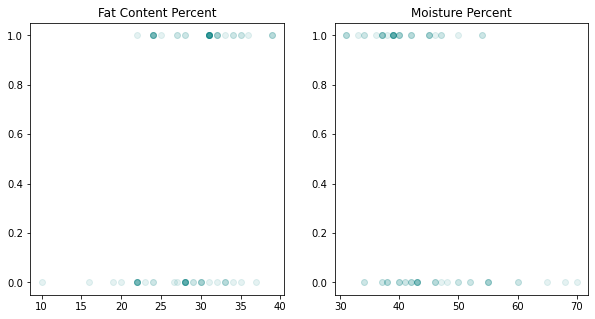

In [230]:
fig, axes = plt.subplots(ncols=2,figsize=(10,5))

axes[0].scatter(y = y_train, x=X_train.iloc[:,0], c='teal', alpha=0.1)
axes[1].scatter(y = y_train, x=X_train.iloc[:,1], c='teal', alpha=0.1)

axes[0].set_title('Fat Content Percent')
axes[1].set_title('Moisture Percent')

plt.show()

With the current model not having a proper test dataset no conclusions can be made about the model performance. Further work on hard coding wine pairings to the original dataset would allow for a proper train/test split so performance metrics can be viewed and tweaked. In addition, more time can be spent on data cleaning to include other input variables such as ripen time, animal source and flavour into the model.

## Citations

Cheese DataBase
* https://open.canada.ca/data/dataset/3c16cd48-3ac3-453f-8260-6f745181c83b

General Thoughts on Wine Pairing
* https://www.cheese.com/wine_matching/

Wine Pairing Table
* https://winefolly.com/wine-pairing/12-classic-wine-and-cheese-pairings-you-have-to-try/

White or Red in General for Cheese
* https://www.castellocheese.com/en-us/articles/how-to-pair-white-wine-cheese/#:~:text=White%20wine%20is%20close%20to,wine%20with%20the%20right%20cheese.